# DataCamp Certification Case Study

### Project Brief

You have been hired as a data scientist at a used car dealership in the UK. The sales team have been having problems with pricing used cars that arrive at the dealership and would like your help. Before they take any company wide action they would like you to work with the Toyota specialist to test your idea. They have already collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

The presentation of your findings should be targeted at the Head of Sales, who has no technical data science background.

The data you will use for this analysis can be accessed here: `"data/toyota.csv"`

In [2]:
# !pip install scikit-optimize

In [75]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectFromModel
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")

# Problem statement
We're tasked with coming up with some methods to help price used cars that arrive at the dealership. Important points to take into account: 
- Cars that are 1500 above the estimated price will not sell
- Delivered the results to Head of Sales (non-technical person)

In [4]:
# Set default parameters for graph and style
plt.rcParams.update({'font.size': 14, 'figure.figsize': (8,8), 'axes.titleweight': 'bold'})
# plt.rcParams()
sns.set_style(style = 'darkgrid')

In [5]:
curr_path = os.getcwd()
df = pd.read_csv(curr_path + '\\toyota.csv')
print(df)

               model  year  price transmission  mileage fuelType  tax   mpg  \
0               GT86  2016  16000       Manual    24089   Petrol  265  36.2   
1               GT86  2017  15995       Manual    18615   Petrol  145  36.2   
2               GT86  2015  13998       Manual    27469   Petrol  265  36.2   
3               GT86  2017  18998       Manual    14736   Petrol  150  36.2   
4               GT86  2017  17498       Manual    36284   Petrol  145  36.2   
...              ...   ...    ...          ...      ...      ...  ...   ...   
6733              IQ  2011   5500    Automatic    30000   Petrol   20  58.9   
6734   Urban Cruiser  2011   4985       Manual    36154   Petrol  125  50.4   
6735   Urban Cruiser  2012   4995       Manual    46000   Diesel  125  57.6   
6736   Urban Cruiser  2011   3995       Manual    60700   Petrol  125  50.4   
6737   Urban Cruiser  2011   4495       Manual    45128   Petrol  125  50.4   

      engineSize  
0            2.0  
1            

# Exploratory Data Analysis

In [6]:
#Check for missing data
df.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

Since there's no missing data, we will not have to impute any data.

In [7]:
# See the average statistics of the dataset
df.describe(include = 'all')

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
count,6738,6738.000000,6738.000000,6738,6738.000000,6738,6738.000000,6738.000000,6738.000000
unique,18,NaN,NaN,4,NaN,4,NaN,NaN,NaN
top,Yaris,NaN,NaN,Manual,NaN,Petrol,NaN,NaN,NaN
freq,2122,NaN,NaN,3826,NaN,4087,NaN,NaN,NaN
mean,NaN,2016.748145,12522.391066,NaN,22857.413921,NaN,94.697240,63.042223,1.471297
std,NaN,2.204062,6345.017587,NaN,19125.464147,NaN,73.880776,15.836710,0.436159
min,NaN,1998.000000,850.000000,NaN,2.000000,NaN,0.000000,2.800000,0.000000
25%,NaN,2016.000000,8290.000000,NaN,9446.000000,NaN,0.000000,55.400000,1.000000
50%,NaN,2017.000000,10795.000000,NaN,18513.000000,NaN,135.000000,62.800000,1.500000
75%,NaN,2018.000000,14995.000000,NaN,31063.750000,NaN,145.000000,69.000000,1.800000


Few observations: 
- It seems that the range of year for cars is from 1998 to 2020, with most of the cars belong to the model year 2016
- Prices range from under 1,000 pounds all the way to almost 60,000 pounds
- Mileage ranges from brand-new (with just 2 miles on odometer) to 174,000 miles. 
- There're 18 unique models. 
- There're 6,738 cars or observations.

## Graphing and visualization

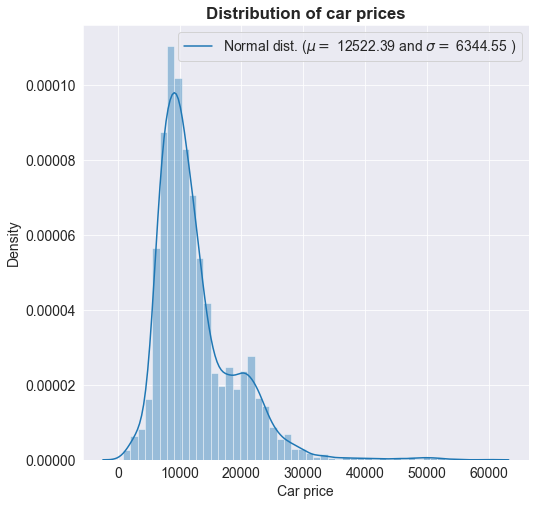

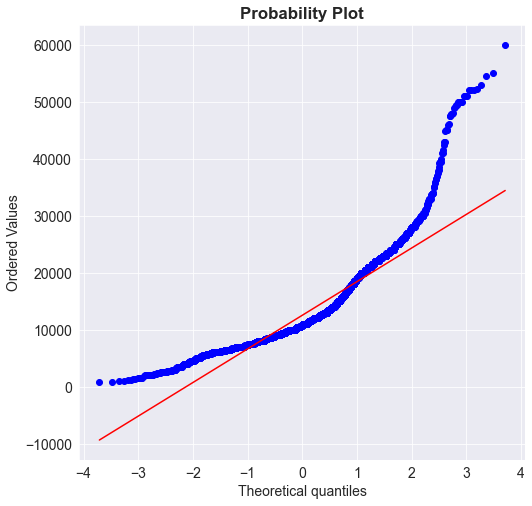

In [150]:
# See the ranges of prices
(mu, sigma) = norm.fit(df['price'])
prices = pd.Series(df['price'], name = 'Car price')
sns.distplot(prices, norm_hist = True )
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.title("Distribution of car prices")
# plt.savefig('Distribution of car prices', bbox_inches = 'tight')

fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)
plt.show()

Most of the prices seem to congregate around the 8,000-15,000 range
From the graphs, we can also see that the distribution of prices is right-skewed. I.e. the mean (mu) or average price is larger than the median (the price that occurs the most). 

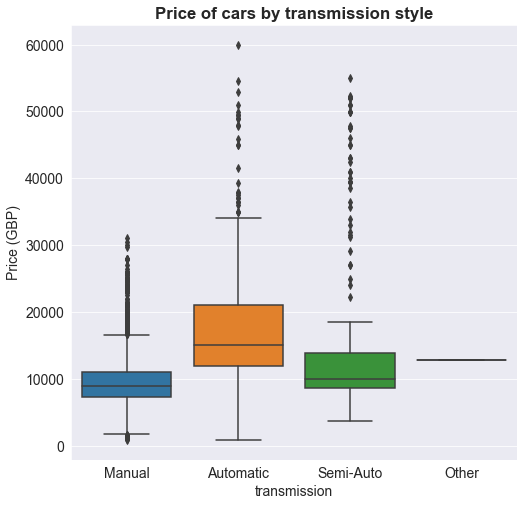

In [151]:
# See the relationships between price and transmission
sns.boxplot(x = 'transmission', y ='price', data = df)
plt.title('Price of cars by transmission style')
plt.ylabel('Price (GBP)')
# plt.savefig('Price of cars by transmission style', bbox_inches = 'tight')
plt.show()

The median car price for manual seems to be around 10,000 GBP, whereas for automatic it's 1.5 times more expensive, at 15,000
Also, according to this plot, we may have some outliers for cars with automatic transmission. 

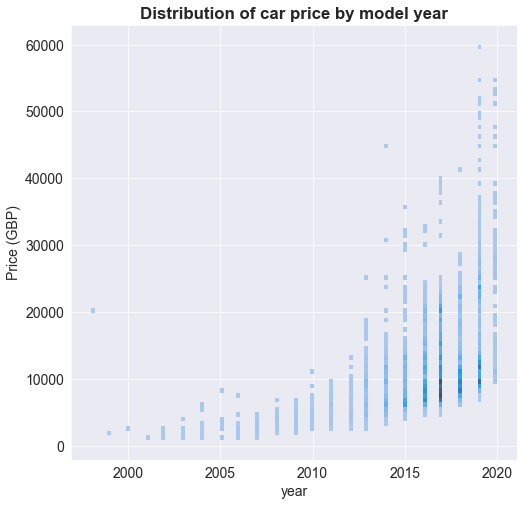

In [152]:
# See the distribution of cars by model year
ax, fig = plt.subplots()
sns.histplot(x = 'year', y = 'price', data = df)
plt.title('Distribution of car price by model year')
plt.ylabel('Price (GBP)')
# plt.savefig('Distribution of car price by model year', bbox_inches = 'tight')
plt.show()

In general, the newer a car is, the more price it will command in the market

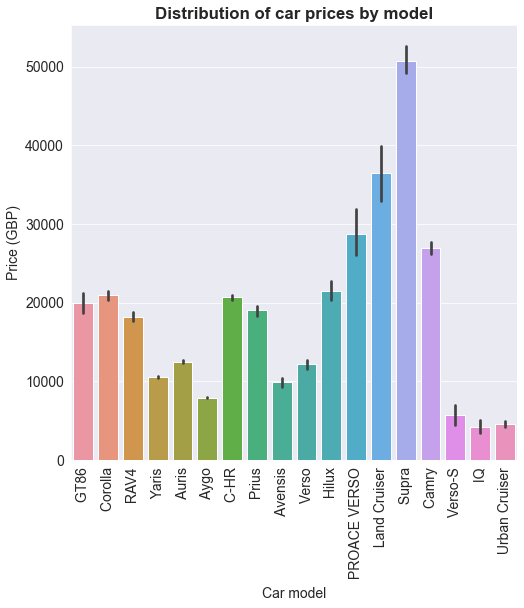

In [154]:
# See the relationship between car model and price
ax, fig = plt.subplots()
sns.barplot(x = 'model', y ='price', data = df)
plt.title('Distribution of car prices by model')
plt.xlabel('Car model')
plt.xticks(rotation = 90)
plt.ylabel('Price (GBP)')
# plt.savefig('Distribution of car price by model', bbox_inches = 'tight')
plt.show()

In [167]:
# Get the number of cars for each model
print(df['model'].value_counts())

# Average price across models
df.groupby(['model'])['price'].mean()

 Yaris            2122
 Aygo             1961
 Auris             712
 C-HR              479
 RAV4              473
 Corolla           267
 Prius             232
 Avensis           115
 Verso             114
 Hilux              86
 GT86               73
 Land Cruiser       51
 PROACE VERSO       15
 Supra              12
 Camry              11
 IQ                  8
 Urban Cruiser       4
 Verso-S             3
Name: model, dtype: int64


model
 Auris            12507.911517
 Avensis           9884.356522
 Aygo              7905.414584
 C-HR             20651.540710
 Camry            26910.090909
 Corolla          20942.734082
 GT86             19908.849315
 Hilux            21504.593023
 IQ                4247.250000
 Land Cruiser     36487.156863
 PROACE VERSO     28680.200000
 Prius            18998.844828
 RAV4             18161.059197
 Supra            50741.000000
 Urban Cruiser     4617.500000
 Verso            12169.157895
 Verso-S           5746.666667
 Yaris            10553.083883
Name: price, dtype: float64

Land cruiser is the model with the highest average price (slightly above 50,000) it seems, and the model with lowest price is IQ (under 5,000) 

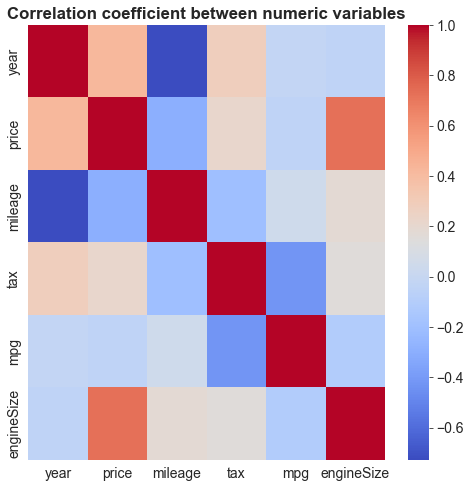

In [170]:
# See the correlation between numerical variables
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap='coolwarm')
plt.title('Correlation coefficient between numeric variables')
# plt.savefig('Correlation between numeric variables', bbox_inches = 'tight')
plt.show()

From the heatmap, we can see that: 
- Price has a strong positive correlation with model year
- Price has a strong negative correlation with mileage, which makes sense
- Mileage has strong negative correlation with model year
- The most surprising finding is price has a strong positive correlation with size of the engine

# Preprocessing
Since we have a few categorical variables, we'll need to create dummy variables for them in order to incorporate them into the model

In [174]:
Numeric = ['year', 'price','mileage','tax','mpg','engineSize']
Category = ['model', 'transmission', 'fuelType']

# Create dummy variables for the categorical variables, dropping 1 variable out so that they will not related to one another 
new_df = pd.get_dummies(df, columns = Category, drop_first = True)
print(new_df.columns)

Index(['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize',
       'model_ Avensis', 'model_ Aygo', 'model_ C-HR', 'model_ Camry',
       'model_ Corolla', 'model_ GT86', 'model_ Hilux', 'model_ IQ',
       'model_ Land Cruiser', 'model_ PROACE VERSO', 'model_ Prius',
       'model_ RAV4', 'model_ Supra', 'model_ Urban Cruiser', 'model_ Verso',
       'model_ Verso-S', 'model_ Yaris', 'transmission_Manual',
       'transmission_Other', 'transmission_Semi-Auto', 'fuelType_Hybrid',
       'fuelType_Other', 'fuelType_Petrol'],
      dtype='object')


In [13]:
# Separate out the data into independent and dependent variables
y = new_df['price']
X = new_df.drop('price', axis = 1)
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    6738 non-null   int64  
 1   mileage                 6738 non-null   int64  
 2   tax                     6738 non-null   int64  
 3   mpg                     6738 non-null   float64
 4   engineSize              6738 non-null   float64
 5   model_ Avensis          6738 non-null   uint8  
 6   model_ Aygo             6738 non-null   uint8  
 7   model_ C-HR             6738 non-null   uint8  
 8   model_ Camry            6738 non-null   uint8  
 9   model_ Corolla          6738 non-null   uint8  
 10  model_ GT86             6738 non-null   uint8  
 11  model_ Hilux            6738 non-null   uint8  
 12  model_ IQ               6738 non-null   uint8  
 13  model_ Land Cruiser     6738 non-null   uint8  
 14  model_ PROACE VERSO     6738 non-null   

In [14]:
# Split the data into 60-20-20 training-validation-testing
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2, train_size= 0.8)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.25, train_size = 0.75)

# Regression models
We'll train several regression models to see which one would provide the best score : 
- Decision Tree Regressor
- Random Forest Regressor
- AdaBoost Regressor
- Gradient Boosting Regressor (not Stochastic GBR)

In [177]:
np.random.seed(25) # Set random state to ensure replicability
# Note: these models were tuned with BayesSearchCV below 
dt = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 1, min_samples_split = 0.01, splitter = 'best')
rf = RandomForestRegressor(n_estimators = 500, min_samples_leaf = 1, max_depth = 13, min_samples_split = 0.02007858746224866)
abr = AdaBoostRegressor(base_estimator = dt, n_estimators = 10, learning_rate = 1.6336944445119845, loss = 'linear')
gbr = GradientBoostingRegressor(max_depth = 20, learning_rate = 0.6360359830847377, n_estimators = 100, subsample = 1,
                               min_samples_split = 1.0, tol = 0.00954875476421266)

# Fit the models
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
abr.fit(X_train, y_train)
gbr.fit(X_train, y_train)

# Make predictions on prices of validations sets
y_pred_dt = dt.predict(X_val)
y_pred_rf = rf.predict(X_val)
y_pred_abr = abr.predict(X_val)
y_pred_gbr = gbr.predict(X_val)

# Score each model using RMSE
rmse_dt = (MSE(y_val, y_pred_dt))**0.5
rmse_rf = (MSE(y_val, y_pred_rf))**0.5
rmse_abr = (MSE(y_val, y_pred_abr))**0.5
rmse_gbr = (MSE(y_val, y_pred_gbr))**0.5

t = PrettyTable()
t.field_names = ["Model used", "RMSE score"]
t.add_rows([
        ["Decision Tree Regressor", '{:.1f}'.format(rmse_dt)],
        ["Random Forest Regressor", '{:.1f}'.format(rmse_rf)],
        ["Ada Boost Regressor", '{:.1f}'.format(rmse_abr)],
        ["Gradient Boosting Regressor", '{:.1f}'.format(rmse_gbr)]])
print(t)

+-----------------------------+------------+
|          Model used         | RMSE score |
+-----------------------------+------------+
|   Decision Tree Regressor   |   1550.9   |
|   Random Forest Regressor   |   1639.2   |
|     Ada Boost Regressor     |   1378.4   |
| Gradient Boosting Regressor |   1746.2   |
+-----------------------------+------------+


In [178]:
# MAE score
# Score each model using MAE
mae_dt = MAE(y_val, y_pred_dt)
mae_rf = MAE(y_val, y_pred_rf)
mae_abr = MAE(y_val, y_pred_abr)
mae_gbr = MAE(y_val, y_pred_gbr)

t2 = PrettyTable()
t2.field_names = ["Model used", "Mean Absolute Error score"]
t2.add_rows([
        ["Decision Tree Regressor", '{:.1f}'.format(mae_dt)],
        ["Random Forest Regressor", '{:.1f}'.format(mae_rf)],
        ["Ada Boost Regressor", '{:.1f}'.format(mae_abr)],
        ["Gradient Boosting Regressor", '{:.1f}'.format(mae_gbr)]])
print(t2)

# R^2 score
r2_dt = r2_score(y_val, y_pred_dt)
r2_rf = r2_score(y_val, y_pred_rf)
r2_abr = r2_score(y_val, y_pred_abr)
r2_gbr = r2_score(y_val, y_pred_gbr)

t3 = PrettyTable()
t3.field_names = ["Model used", "R^2 score"]
t3.add_rows([
        ["Decision Tree Regressor", '{:.1%}'.format(r2_dt)],
        ["Random Forest Regressor", '{:.1%}'.format(r2_rf)],
        ["Ada Boost Regressor", '{:.1%}'.format(r2_abr)],
        ["Gradient Boosting Regressor", '{:.1%}'.format(r2_gbr)]])
print(t3)

+-----------------------------+---------------------------+
|          Model used         | Mean Absolute Error score |
+-----------------------------+---------------------------+
|   Decision Tree Regressor   |           964.4           |
|   Random Forest Regressor   |           990.3           |
|     Ada Boost Regressor     |           865.9           |
| Gradient Boosting Regressor |           1165.4          |
+-----------------------------+---------------------------+
+-----------------------------+-----------+
|          Model used         | R^2 score |
+-----------------------------+-----------+
|   Decision Tree Regressor   |   93.6%   |
|   Random Forest Regressor   |   92.8%   |
|     Ada Boost Regressor     |   94.9%   |
| Gradient Boosting Regressor |   91.9%   |
+-----------------------------+-----------+


Based on the result shown in the tables above, we can see that Ada Boost Regressor has the best score RMSE score, best MAE score, and also the best fit R^2 score. So this will be the model that we will use on the test set to predict prices of cars.

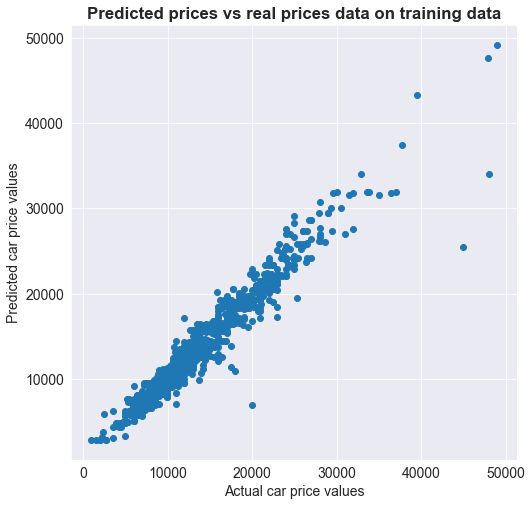

In [23]:
# Plot the predicted values vs. the actual values from Ada Boost model 
plt.scatter(y_val, y_pred_abr)
plt.xlabel('Actual car price values')
plt.ylabel('Predicted car price values')
plt.title('Predicted prices vs real prices data on training data')
plt.show()

# Model tuning
To find the best parameters for the 4 models above

In [128]:
np.random.seed(25)
opt_dt = BayesSearchCV(
    DecisionTreeRegressor(),
    {
        'splitter': ['random', 'best'],
        'max_depth': (1, 10),
        'min_samples_split': (0.01, 1),  # integer valued parameter
        'min_samples_leaf': (1, 10)  # categorical parameter
    },
    n_iter=30,
    cv=3, scoring = 'neg_root_mean_squared_error'
)

opt_dt.fit(X_train, y_train)
print("val. score: %s" % opt_dt.best_score_)
print("best parameters: %s" % opt_dt.best_params_)

val. score: -1231.1964471310469
best parameters: OrderedDict([('max_depth', 10), ('min_samples_leaf', 1), ('min_samples_split', 0.01), ('splitter', 'best')])


In [127]:
np.random.seed(25)
opt_rf = BayesSearchCV(
    RandomForestRegressor(),
    {
        'n_estimators': (10, 500),
        'max_depth': (1, 20),
        'min_samples_split': (0.01, 1),  
        'min_samples_leaf': (1, 10)  
    },
    n_iter=30,
    cv=3, scoring = 'neg_root_mean_squared_error'
)

opt_rf.fit(X_train, y_train)
print("val. score: %s" % opt_rf.best_score_)
print("best parameters: %s" % opt_rf.best_params_)

val. score: -1250.5496547888417
best parameters: OrderedDict([('max_depth', 13), ('min_samples_leaf', 1), ('min_samples_split', 0.02007858746224866), ('n_estimators', 500)])


In [126]:
np.random.seed(25)
opt_abr = BayesSearchCV(
    AdaBoostRegressor(),
    {
        'n_estimators': (10, 500),
        'learning_rate': (0.01, 10),
        'loss': ['exponential', 'linear','square']
    },
    n_iter=30,
    cv=3, scoring = 'neg_root_mean_squared_error'
)

opt_abr.fit(X_train, y_train)
print("val. score: %s" % opt_abr.best_score_)
print("best parameters: %s" % opt_abr.best_params_)

val. score: -1959.8324606423923
best parameters: OrderedDict([('learning_rate', 1.6336944445119845), ('loss', 'linear'), ('n_estimators', 10)])


In [125]:
np.random.seed(25)
opt_gbr = BayesSearchCV(
    GradientBoostingRegressor(),
    {
        'tol': (1e-4, 1e-2),
        'learning_rate': (0.01, 10),
        'min_samples_split': (0.01, 1),
        'max_depth': (10, 100)  
    },
    n_iter=30,
    cv=3, scoring = 'neg_root_mean_squared_error'
)

opt_gbr.fit(X_train, y_train)
print("val. score: %s" % opt_gbr.best_score_)
print("best parameters: %s" % opt_gbr.best_params_)

val. score: -1336.1664089370258
best parameters: OrderedDict([('learning_rate', 0.6360359830847377), ('max_depth', 20), ('min_samples_split', 1.0), ('tol', 0.00954875476421266)])


# Evaluation with the best model
Now we fit the test set with the best model

In [179]:
np.random.seed(25)
best_abr = AdaBoostRegressor(base_estimator = dt, n_estimators = 10, learning_rate = 1.6336944445119845, loss = 'linear')
best_abr.fit(X_train, y_train)
y_pred_best = best_abr.predict(X_test)
rmse_best_abr = (MSE(y_test, y_pred_best))**0.5
mae_best_abr = MAE(y_test, y_pred_best)
r2_best_abr = r2_score(y_test, y_pred_best)

t1 = PrettyTable()
t1.field_names = ["Ada Boost Regressor evaluation method", "Score"]
t1.add_rows([
        ["Root mean square error", '{:.1f}'.format(rmse_best_abr)],
        ["Mean absolute error", '{:.1f}'.format(mae_best_abr)],
        ["R^2 score", '{:.1%}'.format(r2_best_abr)]])
print(t1)

+---------------------------------------+--------+
| Ada Boost Regressor evaluation method | Score  |
+---------------------------------------+--------+
|         Root mean square error        | 1311.4 |
|          Mean absolute error          | 837.9  |
|               R^2 score               | 96.2%  |
+---------------------------------------+--------+


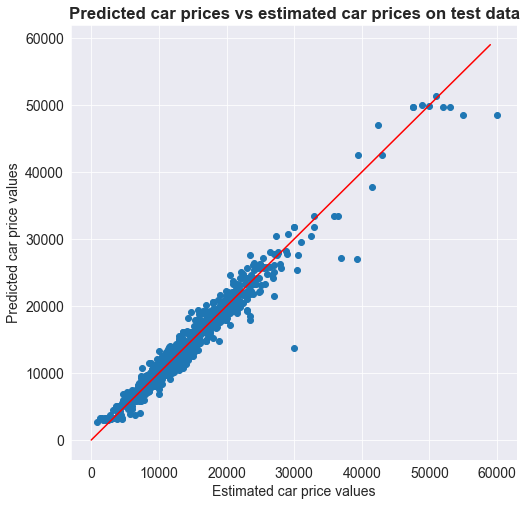

In [186]:
# Plot the predicted values vs. real values
plt.scatter(y_test, y_pred_best)
plt.xlabel('Estimated car price values')
plt.ylabel('Predicted car price values')
linex = np.arange(0, 60000, 1000)
liney = linex
plt.plot(linex, liney, color = 'red')
plt.title('Predicted car prices vs estimated car prices on test data')
# plt.savefig('Predicted car price vs estimated car price', bbox_inches = 'tight')
plt.show()

In [50]:
# Get the difference between predicted and actual values
diff = y_pred_best - y_test

# Calculate the number of instances where the predicted prices are above 1500 GBP
sorted_diff = sorted(diff)
# print(sorted_diff)

num_predictions_above_1500 = sum(price_diff > 1500 for price_diff in sorted_diff)

n = len(y_test)

# Customized accuracy score of the model
accuracy_score = (n - num_predictions_above_1500)/n*100
print('Accuracy score of this model is {:.2f}%'.format(accuracy_score))

1348
Accuracy score of this model is 92.58%


## Feature importance

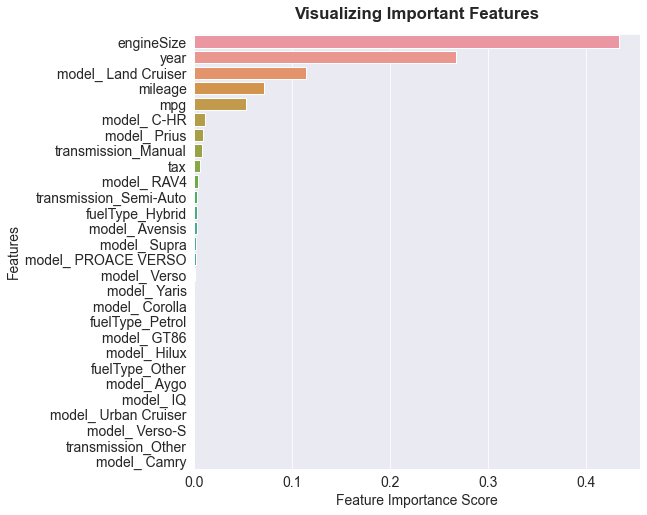

In [187]:
# Get the most important features
features_abr = pd.Series(best_abr.feature_importances_, index = X.columns)

# Sort the importances
sorted_features_abr = features_abr.sort_values(ascending = False)

# Make a plot
sns.barplot(x= sorted_features_abr, y= sorted_features_abr.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", pad=15)
# plt.savefig('Visualizing features importance', bbox_inches = 'tight')
plt.show()

In [144]:
# Attempt to rebuild the model with only the most important features, specifying a threshold of 0.01, or roughly 1% importance or more
np.random.seed(25)

# Create a function to only select the best features
def select_features(X_train, y_train, X_test):
    # Configure to select a subset of features
    selector = SelectFromModel(best_abr, threshold=0.01)
    # Learn relationship from training data
    selector.fit(X_train, y_train)
    # Transform train input data
    X_train_imp = selector.transform(X_train)
    # Transform test input data
    X_test_imp = selector.transform(X_test)
    return X_train_imp, X_test_imp, selector

Looking at this, we can see that now there only remains 9 features that are important. We will use this to build a new model.

In [147]:
# Split data into 80-20 training-testing
X_train_pre, X_test_pre, y_train_imp, y_test_imp = train_test_split(X, y, train_size = 0.8)

# Get the best features only
X_train_imp, X_test_imp, selector = select_features(X_train_pre, y_train_imp, X_test_pre)

# Get the column names of the important features
cols = selector.get_support(indices=True)

# # Create new DataFrames with only important features
X_train_imp = X_train_pre.iloc[:, cols]
X_test_imp = X_test_pre.iloc[:, cols]
print(X_train_imp)

      year  mileage  tax   mpg  engineSize  model_ Land Cruiser  \
16    2017    16444  265  36.2         2.0                    0   
4144  2014    26858    0  69.0         1.0                    0   
78    2019     2193  145  39.2         1.2                    0   
5788  2017    13025  140  74.3         1.8                    0   
1204  2013    71402  125  52.3         1.3                    0   
...    ...      ...  ...   ...         ...                  ...   
2934  2019      541  150  47.9         1.5                    0   
2191  2014    42000    0  80.7         1.5                    0   
6618  2016    51840  260  38.7         2.5                    0   
318   2019     7000  135  85.6         1.8                    0   
5252  2016    23290    0  69.0         1.0                    0   

      model_ PROACE VERSO  fuelType_Petrol  
16                      0                1  
4144                    0                1  
78                      0                1  
5788           

In [148]:
# Refit the model with tuned hyperparameters and re-calculate the score again
np.random.seed(25)
abr_imp = AdaBoostRegressor(base_estimator = dt, n_estimators = 500, learning_rate = 0.042187568245018695, loss = 'exponential')
abr_imp.fit(X_train_imp, y_train_imp)

# Evaluate on test data
y_pred_imp = abr_imp.predict(X_test_imp)
rmse_imp = (MSE(y_test_imp, y_pred_imp))**0.5
mae_imp = MAE(y_test_imp, y_pred_imp)
r2_imp = r2_score(y_test_imp, y_pred_imp)

t4 = PrettyTable()
t4.field_names = ["Model evaluation method", "Score"]
t4.add_rows([
        ["Root mean square error", rmse_imp],
        ["Mean absolute error", mae_imp],
        ["R^2 score", r2_imp]])
print(t4)

+-------------------------+--------------------+
| Model evaluation method |       Score        |
+-------------------------+--------------------+
|  Root mean square error | 1597.4863325836313 |
|   Mean absolute error   |  915.728827235804  |
|        R^2 score        | 0.9399624750063733 |
+-------------------------+--------------------+


Somehow the score (MAE of 915) doesn't improve compared to previous model (MAE of 837) when using only features with significance of 0.01 or more, so we'll discard this result and use the best_abr score model. 

In [107]:
#Re-tuning
np.random.seed(25)
opt_abr = BayesSearchCV(
    AdaBoostRegressor(),
    {
        'n_estimators': (10, 500),
        'learning_rate': (0.01, 10),
        'loss': ['exponential', 'linear','square']
    },
    n_iter=30,
    cv=3, scoring = 'neg_root_mean_squared_error'
)

opt_abr.fit(X_train_imp, y_train_imp)
print("val. score: %s" % opt_abr.best_score_)
print("best parameters: %s" % opt_abr.best_params_)

val. score: -2381.971414292417
best parameters: OrderedDict([('learning_rate', 0.042187568245018695), ('loss', 'exponential'), ('n_estimators', 500)])
